# Stats

By Alejandro Fernández Sánchez

## Initialization

In [1]:
from typing import Any
from neo4j import GraphDatabase, basic_auth, Driver
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
load_dotenv()

True

In [3]:
DB_HOST = os.getenv("NEO4J_HOST")
DB_PORT = os.getenv("NEO4J_PORT")
DB_USER = os.getenv("NEO4J_USER")
DB_PASS = os.getenv("NEO4J_PASS")
LAST_FM_API_KEY = os.getenv("LAST_FM_API_KEY")

# .env validation
assert DB_HOST is not None and \
    DB_PORT is not None and \
    DB_USER is not None and \
    DB_PASS is not None and \
    LAST_FM_API_KEY is not None, \
    "INVALID .env"

In [4]:
driver = GraphDatabase.driver(f"bolt://{DB_HOST}:{DB_PORT}", auth=basic_auth(DB_USER, DB_PASS))
driver

In [5]:
def execute_query_return(driver: Driver, query: str, params: None | dict[str, Any] = None) -> list[dict[str, Any]]:
    with driver.session() as session:
        result = session.run(query, params)  # type: ignore
        return result.data()

In [6]:
!mkdir -p img

## Data obtention

### Artist

#### Counts

In [7]:
# Artist count
query = "match (n:Artist) return count(n) as c;"
total_artist_count = execute_query_return(driver, query)[0]["c"]
total_artist_count

810337

In [8]:
# Artists processed
query = "match (n:Artist {last_fm_call: true}) return count(n) as c;" 
artists_processed = execute_query_return(driver, query)[0]["c"]
print("artists_processed:", artists_processed)
print(f"{artists_processed / total_artist_count * 100:.2f}%")

artists_processed: 344384
42.50%


In [9]:
# Artists processed and in lastfm
query = "match (n:Artist {last_fm_call: true, in_last_fm: true}) return count(n) as c;" 
artists_in_lastfm = execute_query_return(driver, query)[0]["c"]
print("artists_in_lastfm:", artists_in_lastfm)
print(f"{artists_in_lastfm / artists_processed * 100:.2f}%")

artists_in_lastfm: 328875
95.50%


#### Listeners

In [10]:
# Listeners
query = "match (n:Artist {last_fm_call: true, in_last_fm: true}) return n.listeners as l;" 
listeners = sorted([artist["l"] for artist in execute_query_return(driver, query)])
listeners = np.array(listeners)
log_listeners = np.where(listeners > 0, np.log(listeners + 1), listeners)

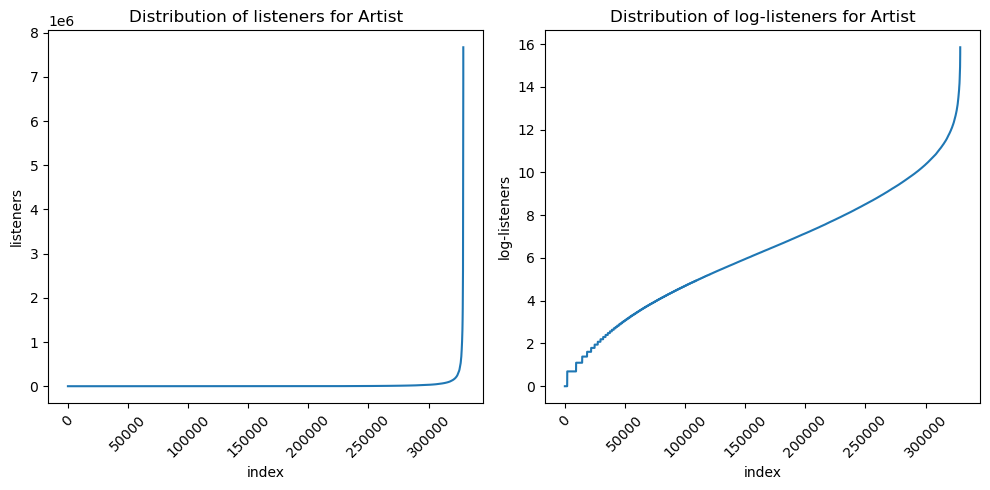

In [11]:
# Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(listeners)
ax1.set_title('Distribution of listeners for Artist')
ax1.set_xlabel('index')
ax1.set_ylabel('listeners')
ax1.tick_params(axis='x', rotation=45)

ax2.plot(log_listeners)
ax2.set_title('Distribution of log-listeners for Artist')
ax2.set_xlabel('index')
ax2.set_ylabel('log-listeners')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("./img/artist_distr_listeners.png")
plt.show()

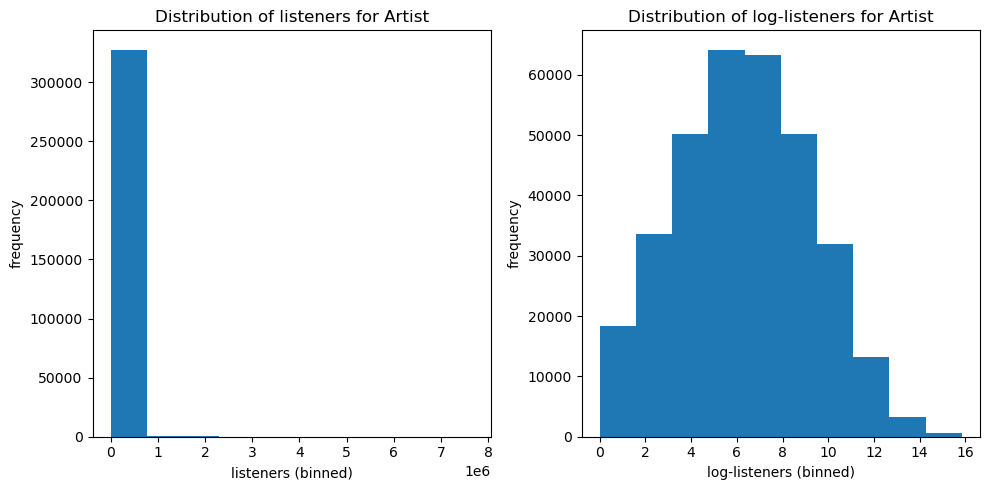

In [12]:
num_bins = 10

listeners_hist, listeners_bins = np.histogram(listeners, bins=num_bins)
log_listeners_hist, log_listeners_bins = np.histogram(log_listeners, bins=num_bins)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.bar(listeners_bins[:-1], listeners_hist, width=np.diff(listeners_bins), align='edge')
ax1.set_title('Distribution of listeners for Artist')
ax1.set_xlabel('listeners (binned)')
ax1.set_ylabel('frequency')

ax2.bar(log_listeners_bins[:-1], log_listeners_hist, width=np.diff(log_listeners_bins), align='edge')
ax2.set_title('Distribution of log-listeners for Artist')
ax2.set_xlabel('log-listeners (binned)')
ax2.set_ylabel('frequency')

plt.tight_layout()
plt.savefig('./img/artist_bars_listeners.png')
plt.show()

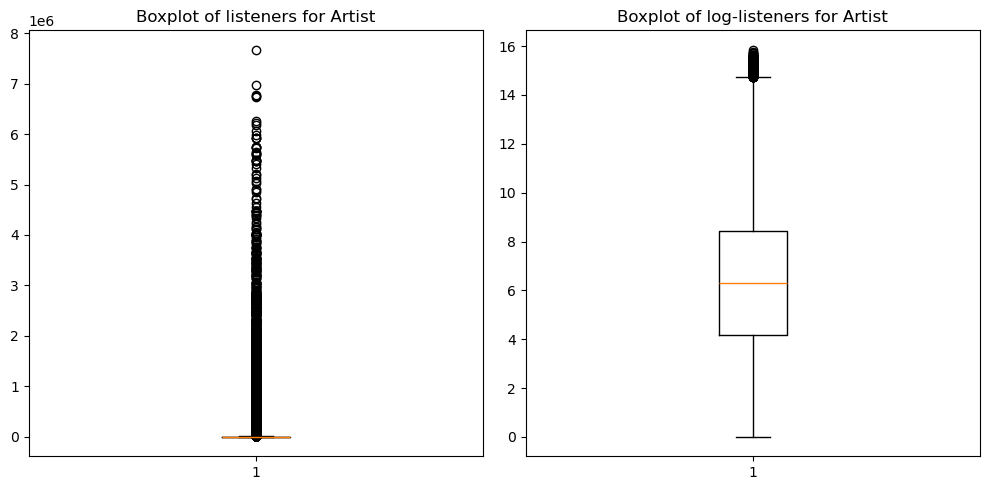

In [13]:
# Boxplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.boxplot(listeners)
ax1.set_title('Boxplot of listeners for Artist')

ax2.boxplot(log_listeners)
ax2.set_title('Boxplot of log-listeners for Artist')

plt.tight_layout()
plt.savefig("./img/artist_boxplots_listeners.png")
plt.show()

In [14]:
# Stats
print("Artist -> Listeners")
print(f"   Min: {np.min(listeners)}")
print(f"   Max: {np.max(listeners)}")
print(f"  Mean: {np.mean(listeners):.2f}")
print(f"    SD: {np.std(listeners):.2f}")
print(f"    Q1: {np.percentile(listeners, 25):.2f}")
print(f"    Q2: {np.percentile(listeners, 50):.2f}")
print(f"    Q3: {np.percentile(listeners, 75):.2f}")

print()

print("Artist -> Log-Listeners")
print(f"  Mean: {np.mean(log_listeners):.2f}")
print(f"    SD: {np.std(log_listeners):.2f}")
print(f"   Min: {np.min(log_listeners)}")
print(f"    Q1: {np.percentile(log_listeners, 25):.2f}")
print(f"    Q2: {np.percentile(log_listeners, 50):.2f}")
print(f"    Q3: {np.percentile(log_listeners, 75):.2f}")
print(f"   Max: {np.max(log_listeners)}")

Artist -> Listeners
   Min: 0
   Max: 7670372
  Mean: 20600.74
    SD: 141147.17
    Q1: 65.00
    Q2: 540.00
    Q3: 4494.00

Artist -> Log-Listeners
  Mean: 6.30
    SD: 2.93
   Min: 0.0
    Q1: 4.19
    Q2: 6.29
    Q3: 8.41
   Max: 15.852875803190976


#### Playcount

In [15]:
# Playcount
query = "match (n:Artist {last_fm_call: true, in_last_fm: true}) return n.playcount as p;" 
playcount = sorted([artist["p"] for artist in execute_query_return(driver, query)])
playcount = np.array(playcount)
log_playcount = np.where(playcount > 0, np.log(playcount + 1), playcount)

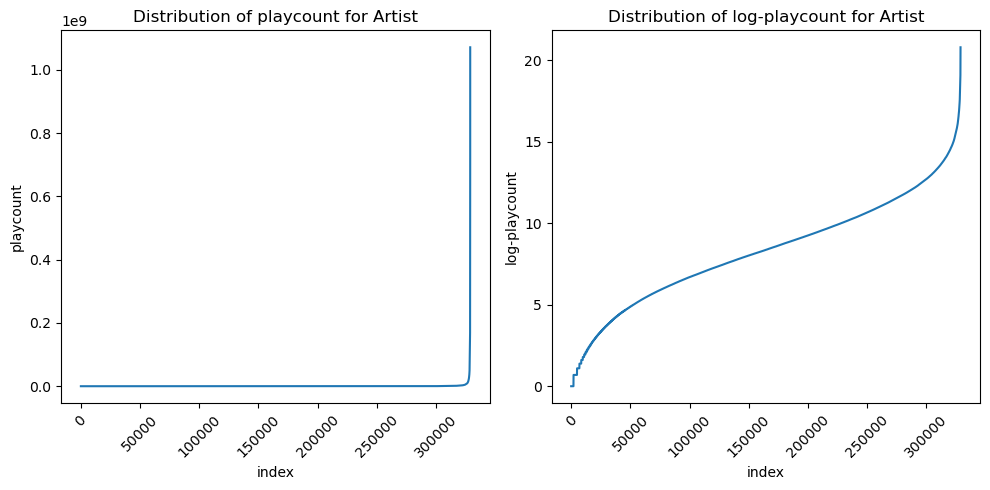

In [16]:
# Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(playcount)
ax1.set_title('Distribution of playcount for Artist')
ax1.set_xlabel('index')
ax1.set_ylabel('playcount')
ax1.tick_params(axis='x', rotation=45)

ax2.plot(log_playcount)
ax2.set_title('Distribution of log-playcount for Artist')
ax2.set_xlabel('index')
ax2.set_ylabel('log-playcount')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("./img/artist_distr_playcount.png")
plt.show()

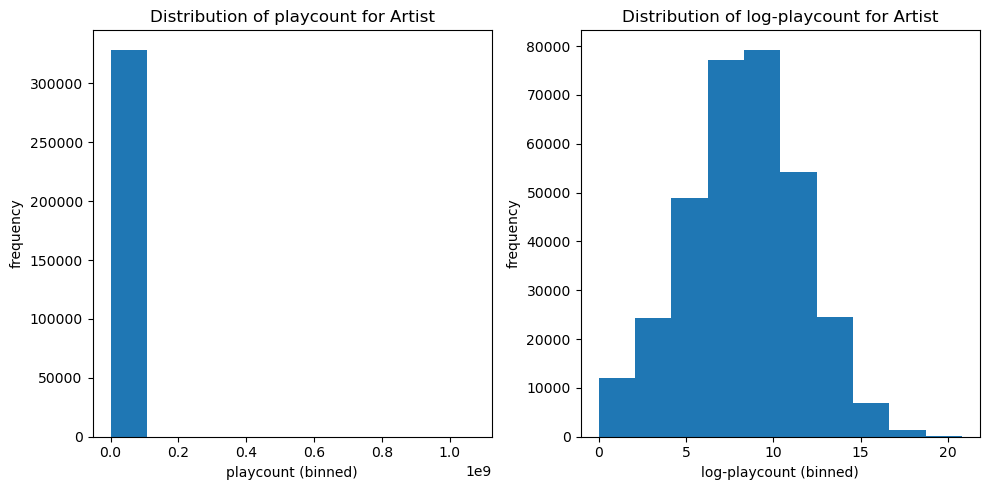

In [17]:
num_bins = 10

playcount_hist, playcount_bins = np.histogram(playcount, bins=num_bins)
log_playcount_hist, log_playcount_bins = np.histogram(log_playcount, bins=num_bins)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.bar(playcount_bins[:-1], playcount_hist, width=np.diff(playcount_bins), align='edge')
ax1.set_title('Distribution of playcount for Artist')
ax1.set_xlabel('playcount (binned)')
ax1.set_ylabel('frequency')

ax2.bar(log_playcount_bins[:-1], log_playcount_hist, width=np.diff(log_playcount_bins), align='edge')
ax2.set_title('Distribution of log-playcount for Artist')
ax2.set_xlabel('log-playcount (binned)')
ax2.set_ylabel('frequency')

plt.tight_layout()
plt.savefig('./img/artist_bars_playcount.png')
plt.show()

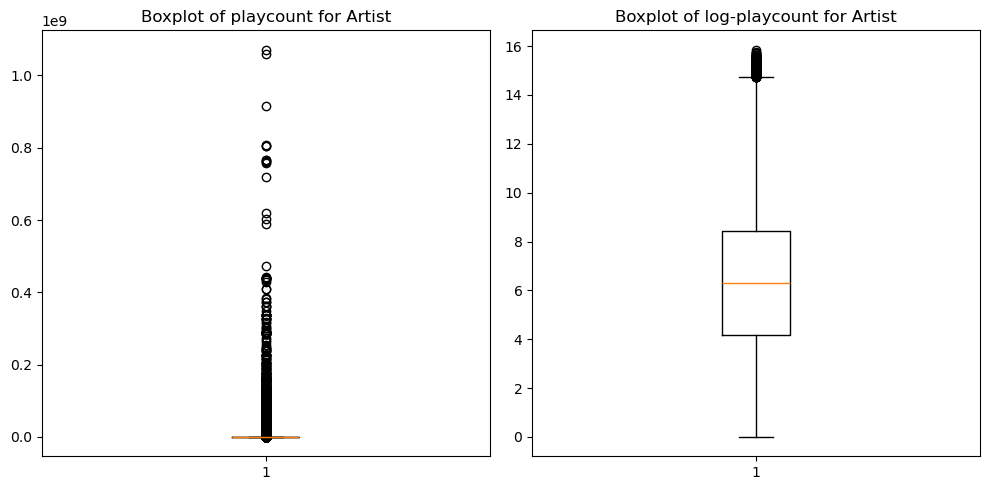

In [18]:
# Boxplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.boxplot(playcount)
ax1.set_title('Boxplot of playcount for Artist')

ax2.boxplot(log_listeners)
ax2.set_title('Boxplot of log-playcount for Artist')

plt.tight_layout()
plt.savefig("./img/artist_boxplots_playcount.png")
plt.show()

In [19]:
# Stats
print("Artist -> Playcount")
print(f"  Mean: {np.mean(playcount):.2f}")
print(f"    SD: {np.std(playcount):.2f}")
print(f"   Min: {np.min(playcount)}")
print(f"    Q1: {np.percentile(playcount, 25):.2f}")
print(f"    Q2: {np.percentile(playcount, 50):.2f}")
print(f"    Q3: {np.percentile(playcount, 75):.2f}")
print(f"   Max: {np.max(playcount)}")

print()

print("Artist -> Log-Playcount")
print(f"  Mean: {np.mean(log_playcount):.2f}")
print(f"    SD: {np.std(log_playcount):.2f}")
print(f"   Min: {np.min(log_playcount)}")
print(f"    Q1: {np.percentile(log_playcount, 25):.2f}")
print(f"    Q2: {np.percentile(log_playcount, 50):.2f}")
print(f"    Q3: {np.percentile(log_playcount, 75):.2f}")
print(f"   Max: {np.max(log_playcount)}")

Artist -> Playcount
  Mean: 521753.06
    SD: 8472957.36
   Min: 0
    Q1: 464.00
    Q2: 4298.00
    Q3: 38185.00
   Max: 1071161796

Artist -> Log-Playcount
  Mean: 8.30
    SD: 3.29
   Min: 0.0
    Q1: 6.14
    Q2: 8.37
    Q3: 10.55
   Max: 20.792009687963674


#### Ended

In [20]:
query = "match (n:Artist) return n.ended as e;" 
ended = sorted([artist["e"] for artist in execute_query_return(driver, query)])
ended = np.array(ended)
log_ended = np.where(ended > 0, np.log(ended + 1), ended)

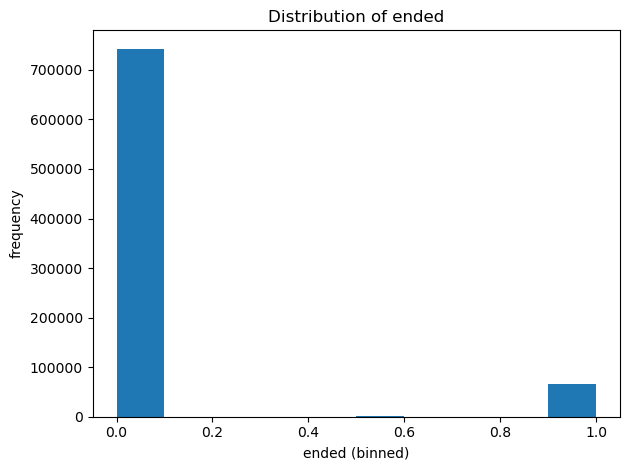

In [21]:
# Bar
num_bins = 10

ended_hist, ended_bins = np.histogram(ended, bins=num_bins)

plt.bar(ended_bins[:-1], ended_hist, width=np.diff(ended_bins), align='edge')
plt.title('Distribution of ended')
plt.xlabel('ended (binned)')
plt.ylabel('frequency')

plt.tight_layout()
plt.savefig('./img/bars_ended.png')
plt.show()

In [22]:
# Stats
print("Ended")
print(f"  Mean: {np.mean(ended):.2f}")
print(f"    SD: {np.std(ended):.2f}")
print(f"   Min: {np.min(ended)}")
print(f"    Q1: {np.percentile(ended, 25):.2f}")
print(f"    Q2: {np.percentile(ended, 50):.2f}")
print(f"    Q3: {np.percentile(ended, 75):.2f}")
print(f"   Max: {np.max(ended)}")

Ended
  Mean: 0.08
    SD: 0.27
   Min: 0.0
    Q1: 0.00
    Q2: 0.00
    Q3: 0.00
   Max: 1.0


#### Begin dates

In [23]:
query = "match (n:Artist) unwind n.begin_dates as d with d where size(d) > 0 return d;" 
begin_dates = [artist["d"] for artist in execute_query_return(driver, query)]
begin_dates = np.sort(np.array(begin_dates).astype(int))

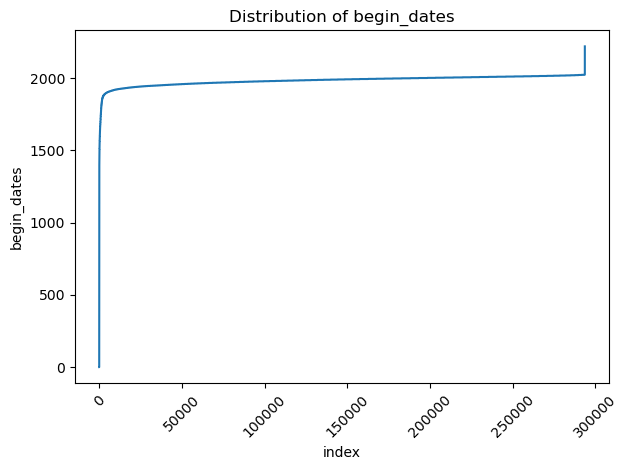

In [24]:
# Distribution
plt.plot(begin_dates)
plt.title('Distribution of begin_dates')
plt.xlabel('index')
plt.ylabel('begin_dates')
plt.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("./img/distr_begin_dates.png")
plt.show()

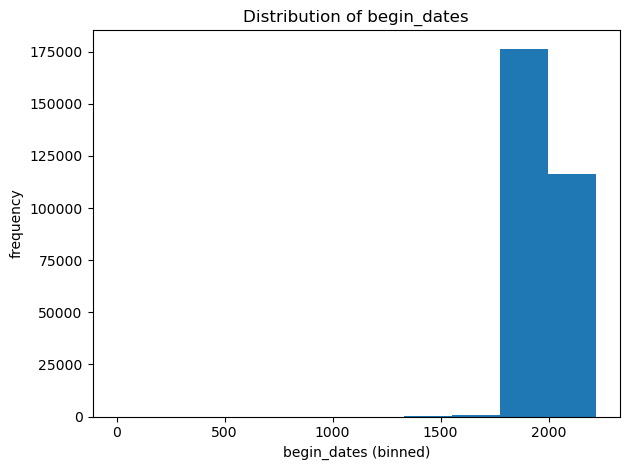

In [25]:
# Bar
num_bins = 10

begin_dates_hist, begin_dates_bins = np.histogram(begin_dates, bins=num_bins)

plt.bar(begin_dates_bins[:-1], begin_dates_hist, width=np.diff(begin_dates_bins), align='edge')
plt.title('Distribution of begin_dates')
plt.xlabel('begin_dates (binned)')
plt.ylabel('frequency')

plt.tight_layout()
plt.savefig('./img/bars_begin_dates.png')
plt.show()

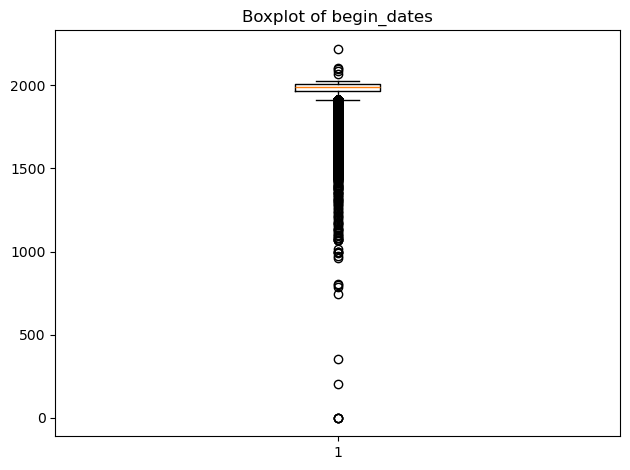

In [26]:
# Boxplot
plt.boxplot(begin_dates)
plt.title('Boxplot of begin_dates')

plt.tight_layout()
plt.savefig("./img/boxplot_begin_dates.png")
plt.show()

In [27]:
# Stats
print("Begin_dates")
print(f"  Mean: {np.mean(begin_dates):.2f}")
print(f"    SD: {np.std(begin_dates):.2f}")
print(f"   Min: {np.min(begin_dates)}")
print(f"    Q1: {np.percentile(begin_dates, 25):.2f}")
print(f"    Q2: {np.percentile(begin_dates, 50):.2f}")
print(f"    Q3: {np.percentile(begin_dates, 75):.2f}")
print(f"   Max: {np.max(begin_dates)}")

Begin_dates
  Mean: 1983.13
    SD: 38.25
   Min: 0
    Q1: 1969.00
    Q2: 1991.00
    Q3: 2006.00
   Max: 2220


#### Begin dates

In [28]:
query = "match (n:Artist) unwind n.end_dates as d with d where size(d) > 0 return d;" 
end_dates = [artist["d"] for artist in execute_query_return(driver, query)]
end_dates = np.sort(np.array(begin_dates).astype(int))

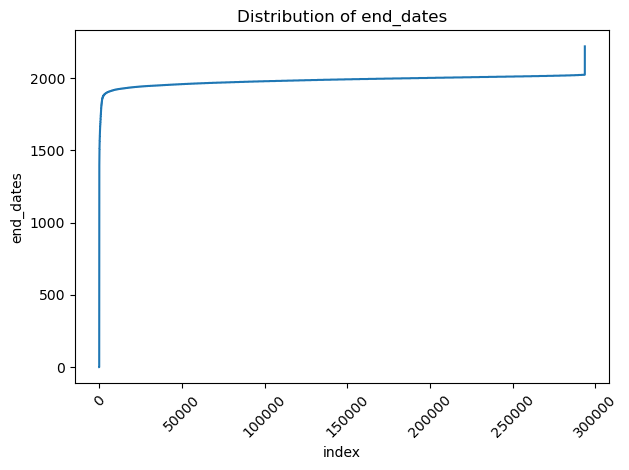

In [29]:
# Distribution
plt.plot(end_dates)
plt.title('Distribution of end_dates')
plt.xlabel('index')
plt.ylabel('end_dates')
plt.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("./img/distr_end_dates.png")
plt.show()

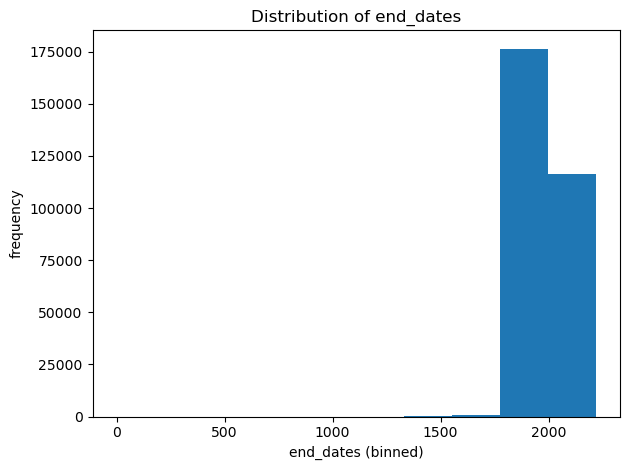

In [30]:
# Bar
num_bins = 10

end_dates_hist, end_dates_bins = np.histogram(end_dates, bins=num_bins)

plt.bar(end_dates_bins[:-1], end_dates_hist, width=np.diff(end_dates_bins), align='edge')
plt.title('Distribution of end_dates')
plt.xlabel('end_dates (binned)')
plt.ylabel('frequency')

plt.tight_layout()
plt.savefig('./img/bars_end_dates.png')
plt.show()

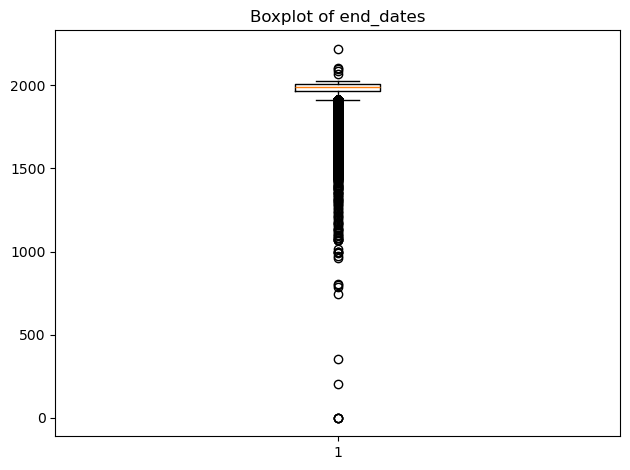

In [31]:
# Boxplot
plt.boxplot(end_dates)
plt.title('Boxplot of end_dates')

plt.tight_layout()
plt.savefig("./img/boxplot_end_dates.png")
plt.show()

In [32]:
# Stats
print("End_dates")
print(f"  Mean: {np.mean(end_dates):.2f}")
print(f"    SD: {np.std(end_dates):.2f}")
print(f"   Min: {np.min(end_dates)}")
print(f"    Q1: {np.percentile(end_dates, 25):.2f}")
print(f"    Q2: {np.percentile(end_dates, 50):.2f}")
print(f"    Q3: {np.percentile(end_dates, 75):.2f}")
print(f"   Max: {np.max(end_dates)}")

End_dates
  Mean: 1983.13
    SD: 38.25
   Min: 0
    Q1: 1969.00
    Q2: 1991.00
    Q3: 2006.00
   Max: 2220


#### Gender

In [33]:
query = "match (n:Artist) return n.gender_1 as g1, n.gender_2 as g2, n.gender_3 as g3, n.gender_4 as g4, n.gender_5 as g5;" 
genders = np.array([
    np.array([artist["g1"], artist["g2"], artist["g3"], artist["g4"], artist["g5"]])
    for artist in execute_query_return(driver, query)
])

In [34]:
# Number of artists for each gender
np.sum(genders, axis=0)

array([219204,  68607,    768,    588,    636])

In [35]:
# Artists with more than one gender
genders[np.sum(genders, axis=1) > 1].shape[0]

412

In [36]:
# Out of those, which are "other" and "non-binary" at the same time
genders[genders[:, 2] & genders[:, 4]].shape[0]

13

#### Type

In [37]:
query = "match (n:Artist) return n.type_1 as t1, n.type_2 as t2, n.type_3 as t3, n.type_4 as t4, n.type_5 as t5, n.type_6 as t6;" 
types = np.array([
    np.array([artist["t1"], artist["t2"], artist["t3"], artist["t4"], artist["t5"], artist["t6"]])
    for artist in execute_query_return(driver, query)
])

In [38]:
# Number of artists for each type
np.sum(types, axis=0)

array([336633, 335818,   1521,   4088,   4459,   3142])

In [39]:
# Artists with more than one type
types[np.sum(types, axis=1) > 1].shape[0]

3348

In [40]:
# Out of those, which are "group" and ("orchestra" or "band") at the same time
types[types[:, 1] & (types[:, 4] | types[:, 5])].shape[0]

16

### Releases

#### Counts

In [41]:
# Release count
query = "match (n:Release) return count(n) as c;"
total_release_count = execute_query_return(driver, query)[0]["c"]
total_release_count

2959869

In [42]:
# Releases processed
query = "match (n:Release {last_fm_call: true}) return count(n) as c;" 
releases_processed = execute_query_return(driver, query)[0]["c"]
print("releases_processed:", releases_processed)
print(f"{releases_processed / total_release_count * 100:.2f}%")

releases_processed: 1183641
39.99%


In [43]:
# Artists processed and in lastfm
query = "match (n:Release {last_fm_call: true, in_last_fm: true}) return count(n) as c;" 
releases_in_lastfm = execute_query_return(driver, query)[0]["c"]
print("releases_in_lastfm:", releases_in_lastfm)
print(f"{releases_in_lastfm / releases_processed * 100:.2f}%")

releases_in_lastfm: 559810
47.30%


#### Listeners

In [44]:
# Listeners
query = "match (n:Release {last_fm_call: true, in_last_fm: true}) return n.listeners as l;" 
listeners = sorted([release["l"] for release in execute_query_return(driver, query)])
listeners = np.array(listeners)
log_listeners = np.where(listeners > 0, np.log(listeners + 1), listeners)

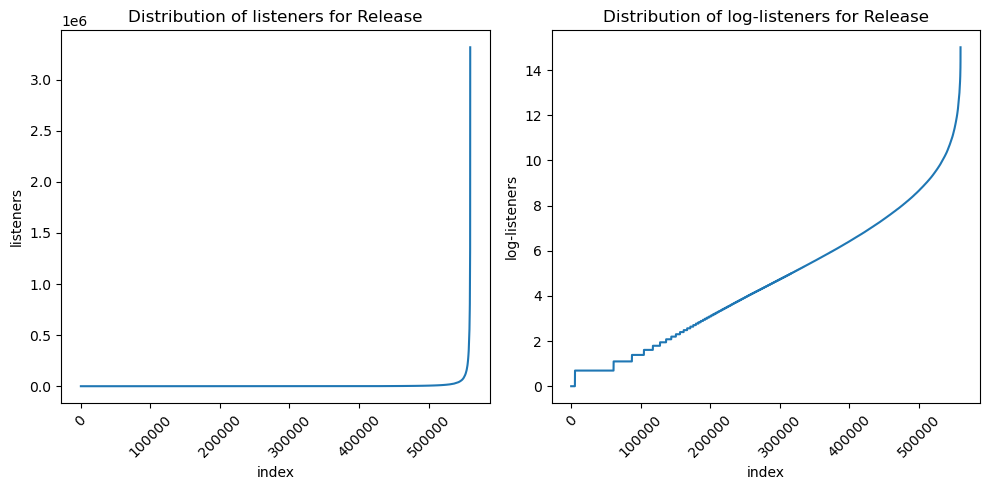

In [45]:
# Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(listeners)
ax1.set_title('Distribution of listeners for Release')
ax1.set_xlabel('index')
ax1.set_ylabel('listeners')
ax1.tick_params(axis='x', rotation=45)

ax2.plot(log_listeners)
ax2.set_title('Distribution of log-listeners for Release')
ax2.set_xlabel('index')
ax2.set_ylabel('log-listeners')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("./img/release_distr_listeners.png")
plt.show()

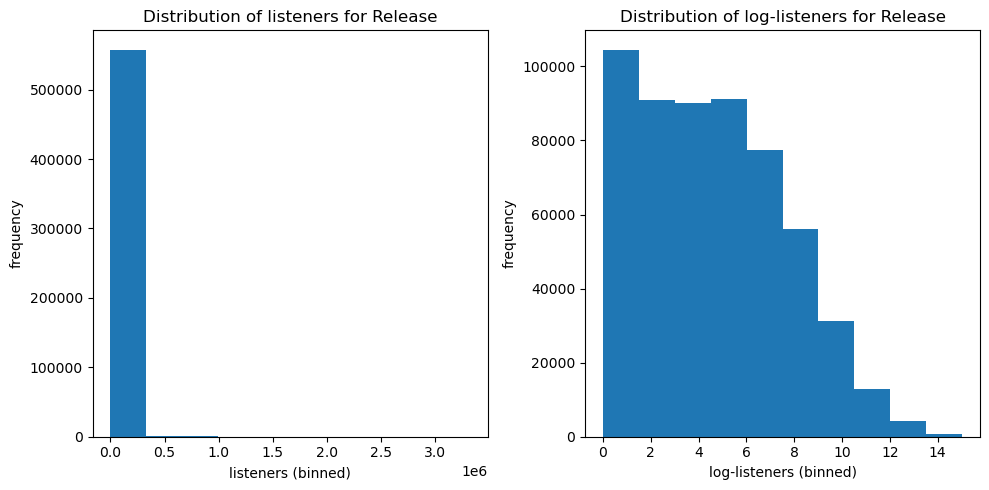

In [46]:
num_bins = 10

listeners_hist, listeners_bins = np.histogram(listeners, bins=num_bins)
log_listeners_hist, log_listeners_bins = np.histogram(log_listeners, bins=num_bins)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.bar(listeners_bins[:-1], listeners_hist, width=np.diff(listeners_bins), align='edge')
ax1.set_title('Distribution of listeners for Release')
ax1.set_xlabel('listeners (binned)')
ax1.set_ylabel('frequency')

ax2.bar(log_listeners_bins[:-1], log_listeners_hist, width=np.diff(log_listeners_bins), align='edge')
ax2.set_title('Distribution of log-listeners for Release')
ax2.set_xlabel('log-listeners (binned)')
ax2.set_ylabel('frequency')

plt.tight_layout()
plt.savefig('./img/release_bars_listeners.png')
plt.show()

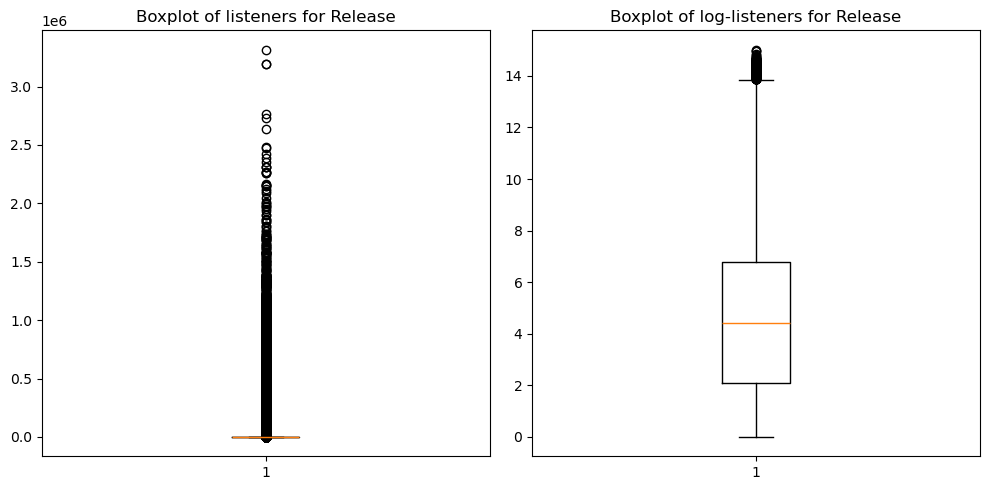

In [47]:
# Boxplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.boxplot(listeners)
ax1.set_title('Boxplot of listeners for Release')

ax2.boxplot(log_listeners)
ax2.set_title('Boxplot of log-listeners for Release')

plt.tight_layout()
plt.savefig("./img/release_boxplots_listeners.png")
plt.show()

In [48]:
# Stats
print("Release -> Listeners")
print(f"   Min: {np.min(listeners)}")
print(f"   Max: {np.max(listeners)}")
print(f"  Mean: {np.mean(listeners):.2f}")
print(f"    SD: {np.std(listeners):.2f}")
print(f"    Q1: {np.percentile(listeners, 25):.2f}")
print(f"    Q2: {np.percentile(listeners, 50):.2f}")
print(f"    Q3: {np.percentile(listeners, 75):.2f}")

print()

print("Release -> Log-Listeners")
print(f"  Mean: {np.mean(log_listeners):.2f}")
print(f"    SD: {np.std(log_listeners):.2f}")
print(f"   Min: {np.min(log_listeners)}")
print(f"    Q1: {np.percentile(log_listeners, 25):.2f}")
print(f"    Q2: {np.percentile(log_listeners, 50):.2f}")
print(f"    Q3: {np.percentile(log_listeners, 75):.2f}")
print(f"   Max: {np.max(log_listeners)}")

Release -> Listeners
   Min: 0
   Max: 3315889
  Mean: 7123.03
    SD: 52770.39
    Q1: 7.00
    Q2: 82.00
    Q3: 889.00

Release -> Log-Listeners
  Mean: 4.66
    SD: 2.96
   Min: 0.0
    Q1: 2.08
    Q2: 4.42
    Q3: 6.79
   Max: 15.014236622190118


#### Playcount

In [49]:
# Playcount
query = "match (n:Artist {last_fm_call: true, in_last_fm: true}) return n.playcount as p;" 
playcount = sorted([artist["p"] for artist in execute_query_return(driver, query)])
playcount = np.array(playcount)
log_playcount = np.where(playcount > 0, np.log(playcount + 1), playcount)

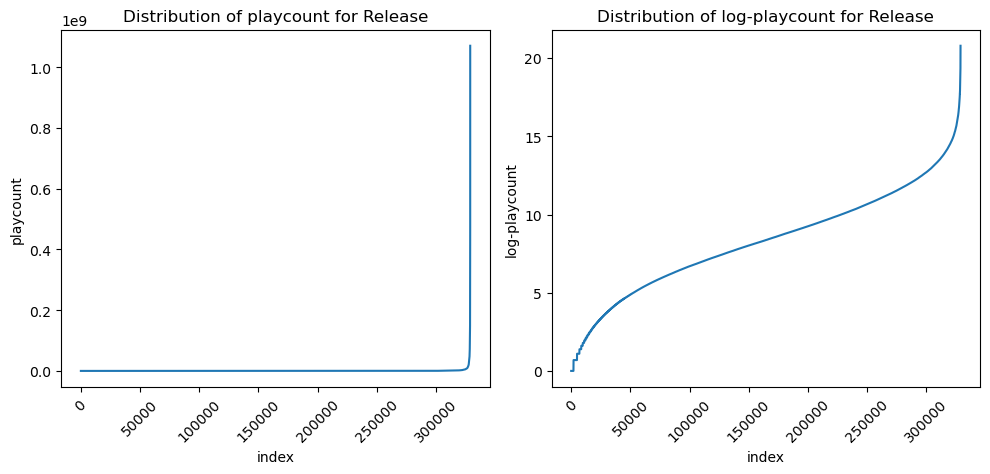

In [50]:
# Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(playcount)
ax1.set_title('Distribution of playcount for Release')
ax1.set_xlabel('index')
ax1.set_ylabel('playcount')
ax1.tick_params(axis='x', rotation=45)

ax2.plot(log_playcount)
ax2.set_title('Distribution of log-playcount for Release')
ax2.set_xlabel('index')
ax2.set_ylabel('log-playcount')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("./img/release_distr_playcount.png")
plt.show()

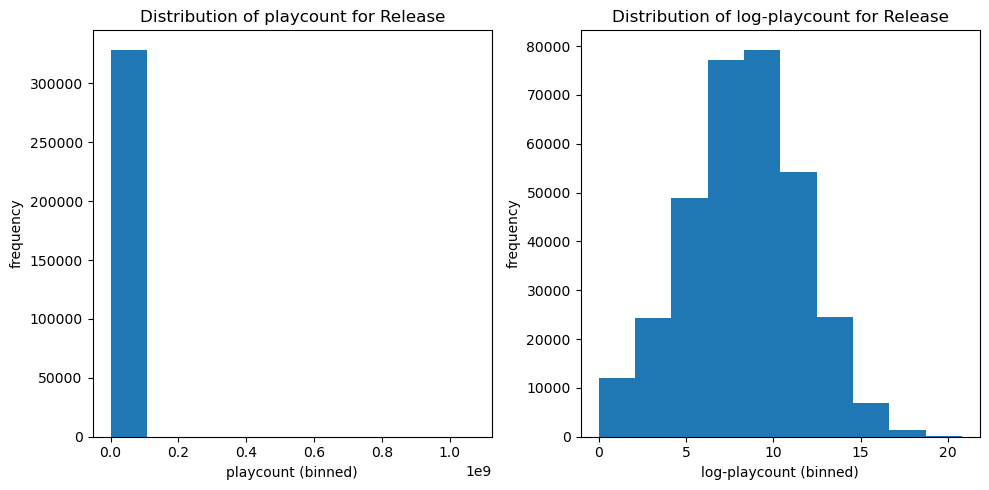

In [51]:
num_bins = 10

playcount_hist, playcount_bins = np.histogram(playcount, bins=num_bins)
log_playcount_hist, log_playcount_bins = np.histogram(log_playcount, bins=num_bins)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.bar(playcount_bins[:-1], playcount_hist, width=np.diff(playcount_bins), align='edge')
ax1.set_title('Distribution of playcount for Release')
ax1.set_xlabel('playcount (binned)')
ax1.set_ylabel('frequency')

ax2.bar(log_playcount_bins[:-1], log_playcount_hist, width=np.diff(log_playcount_bins), align='edge')
ax2.set_title('Distribution of log-playcount for Release')
ax2.set_xlabel('log-playcount (binned)')
ax2.set_ylabel('frequency')

plt.tight_layout()
plt.savefig('./img/release_bars_playcount.png')
plt.show()

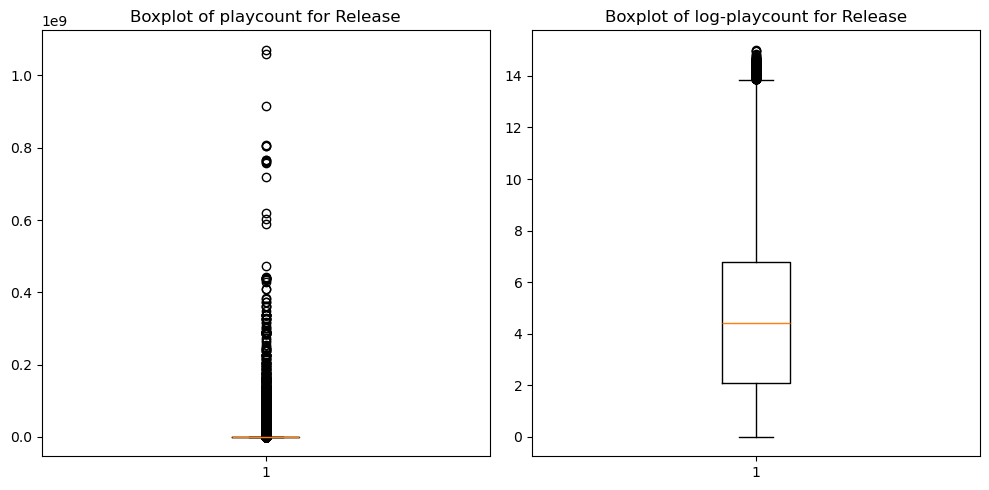

In [52]:
# Boxplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.boxplot(playcount)
ax1.set_title('Boxplot of playcount for Release')

ax2.boxplot(log_listeners)
ax2.set_title('Boxplot of log-playcount for Release')

plt.tight_layout()
plt.savefig("./img/release_boxplots_playcount.png")
plt.show()

In [53]:
# Stats
print("Release -> Playcount")
print(f"  Mean: {np.mean(playcount):.2f}")
print(f"    SD: {np.std(playcount):.2f}")
print(f"   Min: {np.min(playcount)}")
print(f"    Q1: {np.percentile(playcount, 25):.2f}")
print(f"    Q2: {np.percentile(playcount, 50):.2f}")
print(f"    Q3: {np.percentile(playcount, 75):.2f}")
print(f"   Max: {np.max(playcount)}")

print()

print("Release -> Log-Playcount")
print(f"  Mean: {np.mean(log_playcount):.2f}")
print(f"    SD: {np.std(log_playcount):.2f}")
print(f"   Min: {np.min(log_playcount)}")
print(f"    Q1: {np.percentile(log_playcount, 25):.2f}")
print(f"    Q2: {np.percentile(log_playcount, 50):.2f}")
print(f"    Q3: {np.percentile(log_playcount, 75):.2f}")
print(f"   Max: {np.max(log_playcount)}")

Release -> Playcount
  Mean: 521753.06
    SD: 8472957.36
   Min: 0
    Q1: 464.00
    Q2: 4298.00
    Q3: 38185.00
   Max: 1071161796

Release -> Log-Playcount
  Mean: 8.30
    SD: 3.29
   Min: 0.0
    Q1: 6.14
    Q2: 8.37
    Q3: 10.55
   Max: 20.792009687963674


#### Artist count

In [54]:
query = "match (n:Release) return n.artist_count as c;"
count = [r["c"] for r in execute_query_return(driver, query)]

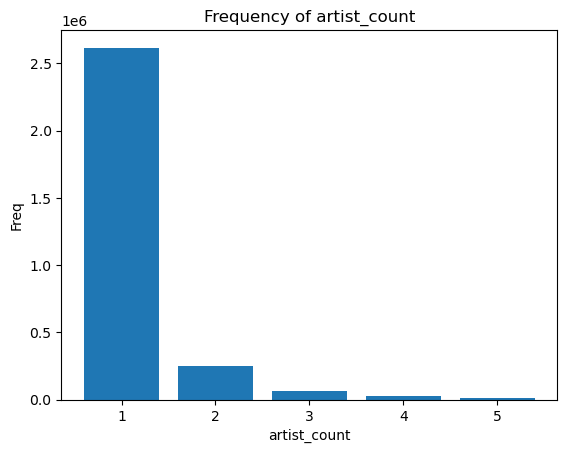

In [55]:
heights = [
    len(list(filter(lambda x: x == i, count)))
    for i in (str(j) for j in range(1, 6))
]

plt.bar(np.arange(1, 6), heights)
plt.title("Frequency of artist_count")
plt.xlabel("artist_count")
plt.ylabel("Freq")
plt.savefig("./img/artist_count_freqs.png")
plt.show()

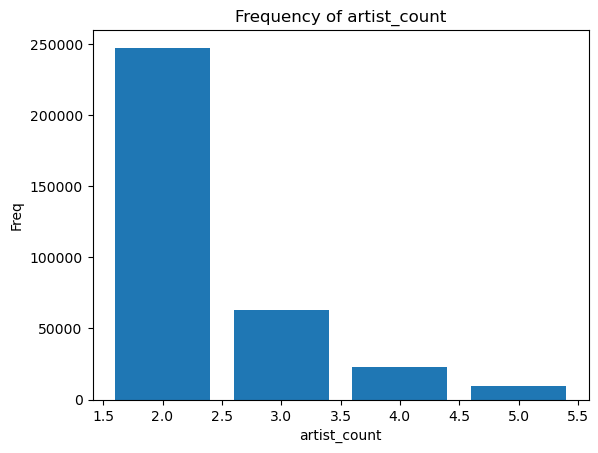

In [56]:
plt.bar(np.arange(2, 6), heights[1:])
plt.title("Frequency of artist_count")
plt.xlabel("artist_count")
plt.ylabel("Freq")
plt.savefig("./img/artist_count_freqs2.png")
plt.show()

In [57]:
for i, height in enumerate(heights):
    print(f"artist_count == {i + 1}: {height}")

artist_count == 1: 2616851
artist_count == 2: 247534
artist_count == 3: 62967
artist_count == 4: 23002
artist_count == 5: 9515


#### Date

In [58]:
query = "match (n:Release) where n.date.year <= 2024 return n.date.month as m, n.date.year as y;"
dates = execute_query_return(driver, query)
len(dates)

2907908

In [59]:
years = sorted([date["y"] for date in dates])
months = sorted([date["m"] for date in dates])

#### Month

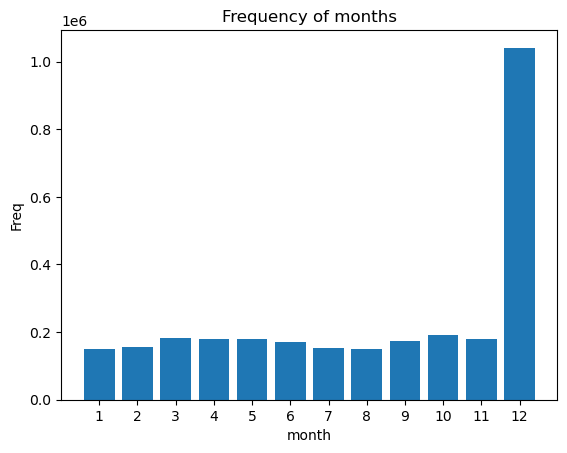

In [60]:
heights = [
    len(list(filter(lambda x: x == i, months)))
    for i in range(1, 13)
]

plt.bar(np.arange(1, 13), heights)
plt.title("Frequency of months")
plt.xlabel("month")
plt.ylabel("Freq")
plt.xticks(np.arange(1, 13))
plt.savefig("./img/month_freqs.png")
plt.show()

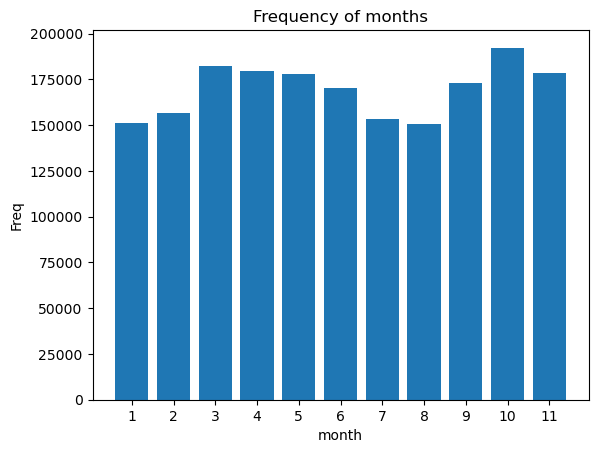

In [61]:
plt.bar(np.arange(1, 12), heights[:-1])
plt.title("Frequency of months")
plt.xlabel("month")
plt.xticks(np.arange(1, 12))
plt.ylabel("Freq")
plt.savefig("./img/month_freqs.png")
plt.show()

In [62]:
for i, height in enumerate(heights):
    print(f"month == {i + 1:2}: {height}")

month ==  1: 151260
month ==  2: 156899
month ==  3: 182291
month ==  4: 179609
month ==  5: 178159
month ==  6: 170310
month ==  7: 153619
month ==  8: 150751
month ==  9: 173127
month == 10: 192335
month == 11: 178504
month == 12: 1041044


#### Year

In [63]:
# If not the plots don't show anything
years = list(filter(lambda year: year >= 1950, years))

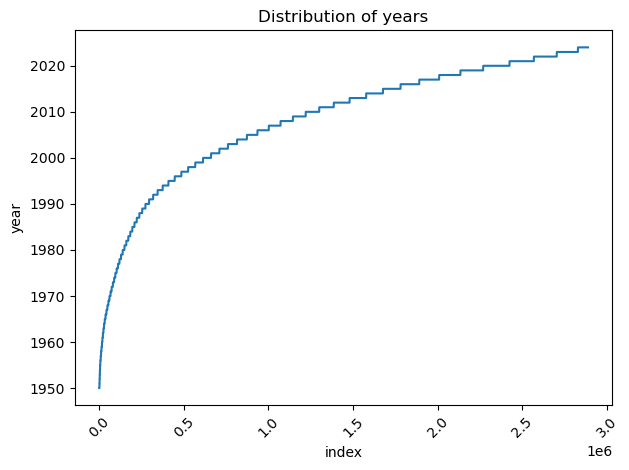

In [64]:
# Distribution
plt.plot(years)
plt.title('Distribution of years')
plt.xlabel('index')
plt.ylabel('year')
plt.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("./img/distr_years.png")
plt.show()

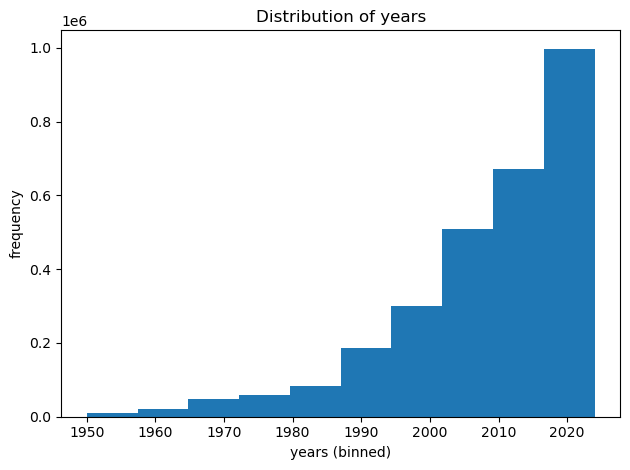

In [65]:
# Bar
num_bins = 10

end_dates_hist, end_dates_bins = np.histogram(years, bins=num_bins)

plt.bar(end_dates_bins[:-1], end_dates_hist, width=np.diff(end_dates_bins), align='edge')
plt.title('Distribution of years')
plt.xlabel('years (binned)')
plt.ylabel('frequency')

plt.tight_layout()
plt.savefig('./img/bars_years.png')
plt.show()

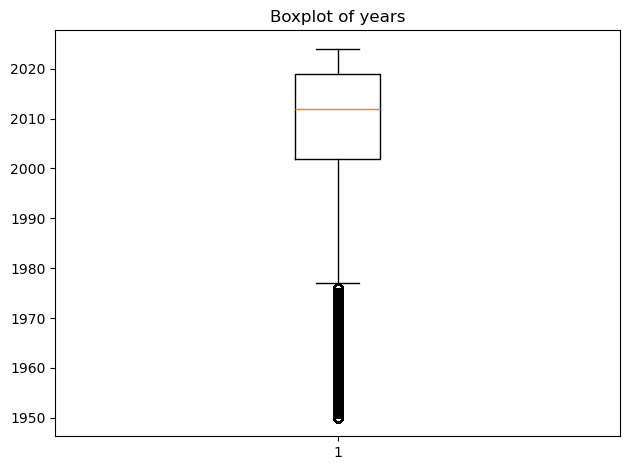

In [66]:
# Boxplot
plt.boxplot(years)
plt.title('Boxplot of years')

plt.tight_layout()
plt.savefig("./img/boxplot_years.png")
plt.show()

In [67]:
# Stats
print("Years")
print(f"  Mean: {np.mean(years):.2f}")
print(f"    SD: {np.std(years):.2f}")
print(f"   Min: {np.min(years)}")
print(f"    Q1: {np.percentile(years, 25)}")
print(f"    Q2: {np.percentile(years, 50)}")
print(f"    Q3: {np.percentile(years, 75)}")
print(f"   Max: {np.max(years)}")

Years
  Mean: 2008.39
    SD: 13.52
   Min: 1950
    Q1: 2002.0
    Q2: 2012.0
    Q3: 2019.0
   Max: 2024


### Tag

In [68]:
query = "match (n:Tag)-[r:TAGS]->() return n.name as n, count(r) as r;"
tags = execute_query_return(driver, query)

In [69]:
tags = sorted(tags, key=lambda x: x["r"])
names = [tag["n"] for tag in tags]
freqs = [tag["r"] for tag in tags]

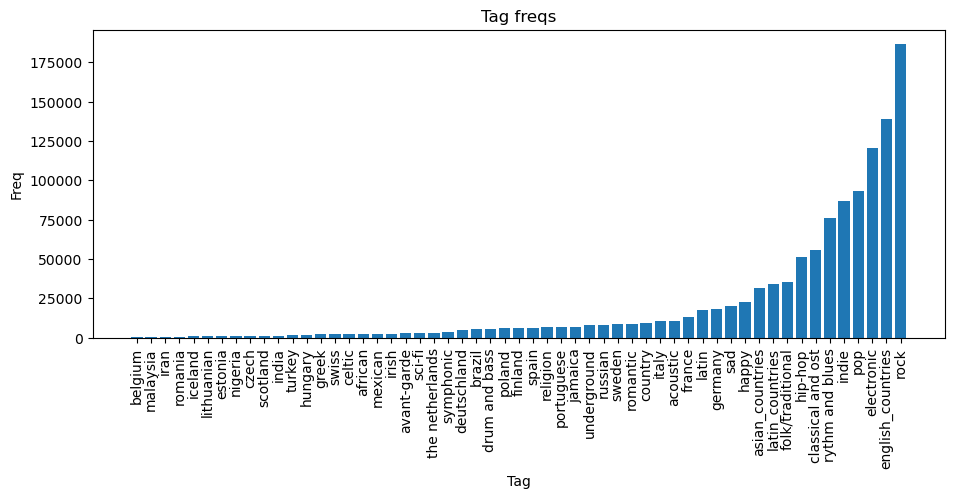

In [70]:
plt.figure(figsize=(11, 4))

plt.bar(names, freqs)
plt.xlabel("Tag")
plt.xticks(rotation=90)
plt.ylabel("Freq")
plt.title("Tag freqs")
plt.savefig("./img/tag_bar")
plt.show()

In [71]:
largest_name = max(map(len, names))
largest_num = max(map(lambda freq: len(str(freq)), freqs))
for name, freq in zip(names, freqs):
    print(f"{" " * (largest_name - len(name))}{name}: {freq}")

          belgium: 144
         malaysia: 397
             iran: 476
          romania: 540
          iceland: 705
       lithuanian: 731
          estonia: 804
          nigeria: 814
            czech: 838
         scotland: 1015
            india: 1185
           turkey: 1683
          hungary: 1817
            greek: 1975
            swiss: 2036
           celtic: 2222
          african: 2256
          mexican: 2335
            irish: 2365
      avant-garde: 2646
           sci-fi: 2715
  the netherlands: 3056
        symphonic: 3702
      deutschland: 5080
           brazil: 5188
    drum and bass: 5254
           poland: 5972
          finland: 6324
            spain: 6411
         religion: 6432
       portuguese: 6523
          jamaica: 6933
      underground: 7757
          russian: 8130
           sweden: 8575
         romantic: 8699
          country: 9235
            italy: 10264
         acoustic: 10310
           france: 13252
            latin: 17630
          germany: 17

### Relationships

In [72]:
relationships = [
    "WORKED_IN",
    "WORKED_BY",
    "COLLAB_WITH",
    "MUSICALLY_RELATED_TO",
    "PERSONALLY_RELATED_TO",
    "LINKED_TO",
    "LAST_FM_MATCH",
    "HAS_TAG",
    "TAGS",
]
longest_name = max(map(len, relationships))
for name in relationships:
    query = f"match ()-[r:{name}]->() return count(r) as r;"
    result = execute_query_return(driver, query)[0]["r"]
    print(f"{" " * (longest_name - len(name))}{name}: {result}")

            WORKED_IN: 3435334
            WORKED_BY: 3435334
          COLLAB_WITH: 888376
 MUSICALLY_RELATED_TO: 226912
PERSONALLY_RELATED_TO: 14580
            LINKED_TO: 17724
        LAST_FM_MATCH: 44455248
              HAS_TAG: 1154619
                 TAGS: 1154619


## Cleanup

In [73]:
driver.close()